In [1]:
from dataclasses import dataclass, field
import copy
from enum import Enum, auto
import random
import pandas as pd
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[4, 9, 11, 2, 11, 13, 6, 13, 7, 5]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h18, cards=[6, 3, 9], doubled=False),
  Hand(score=h22, cards=[2, 9, 2, 12], doubled=False),
  <HandOutcome.WIN: 1>),
 ('strat_nobust',
  Hand(score=h13, cards=[6, 3, 4], doubled=False),
  Hand(score=h22, cards=[2, 9, 2, 12], doubled=False),
  <HandOutcome.WIN: 1>)]

## Aggregate and summarize the data from the simulations

In [19]:

def generate_row_from_player(player):
    (strat, hand_p, hand_d, outcome) = player
    return {'strategy': strat, 'hand_start': hand_p.cards[:2], 'dealer_card': hand_d.cards[0], 'hand_end': hand_p.cards, 'dealer_hand': hand_d.cards, 'outcome': outcome}

def generate_rows_from_round(r):
    return [generate_row_from_player(player) for player in r]

strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [6, 2],
  'dealer_card': 12,
  'hand_end': [6, 2, 7],
  'dealer_hand': [12, 7],
  'outcome': <HandOutcome.LOSE: -1>},
 {'strategy': 'strat_dealer',
  'hand_start': [6, 2],
  'dealer_card': 12,
  'hand_end': [6, 2, 7, 12],
  'dealer_hand': [12, 7],
  'outcome': <HandOutcome.LOSE: -1>}]

In [20]:
def run_n_sim_trials(strats, n):
    sims = [generate_rows_from_round(bj.play_one_round(strats)) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

def summarize_totals(sims):
    def outcome_name(x): return x.head(1) # The function name will be used as the column name
    outcome_counts = sims.groupby(['strategy', 'outcome_value'])['outcome_name'].agg([len, outcome_name])
    outcome_summary = outcome_counts.reset_index().set_index('strategy').drop(['outcome_value'], axis=1).pivot(columns=['outcome_name'])

    # The empty cells are NaNs; fill the NaNs and convert back to int
    for col in outcome_summary.columns:
        outcome_summary[col] = outcome_summary[col].fillna(0).apply(int)
        
    outcome_summary['mean_outcome'] = sims.groupby('strategy')['outcome_value'].mean()
    
    return outcome_summary


sim_results = run_n_sim_trials([strat_nobust, strat_dealer], 1000)
sim_results, summarize_totals(sim_results)

(          strategy hand_start  dealer_card            hand_end  \
 0     strat_nobust    [5, 11]            4             [5, 11]   
 1     strat_dealer    [5, 11]            4          [5, 11, 7]   
 2     strat_nobust    [6, 13]            3             [6, 13]   
 3     strat_dealer    [6, 13]            3          [6, 13, 4]   
 4     strat_nobust    [10, 9]           11             [10, 9]   
 ...            ...        ...          ...                 ...   
 1995  strat_dealer     [1, 2]           10  [1, 2, 1, 8, 1, 4]   
 1996  strat_nobust    [6, 10]            7             [6, 10]   
 1997  strat_dealer    [6, 10]            7          [6, 10, 4]   
 1998  strat_nobust    [12, 7]            1             [12, 7]   
 1999  strat_dealer    [12, 7]            1             [12, 7]   
 
          dealer_hand           outcome  outcome_value outcome_name  
 0         [4, 9, 13]   HandOutcome.WIN            1.0          WIN  
 1         [4, 9, 13]  HandOutcome.LOSE           -1.0

In [21]:
def strat_simple(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = run_n_sim_trials([strat_simple], 1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card     hand_end   dealer_hand  \
 0   simple     [5, 2]            3    [5, 2, 8]    [3, 7, 11]   
 1   simple     [7, 8]           10    [7, 8, 9]       [10, 1]   
 2   simple    [13, 3]            7  [13, 3, 12]    [7, 4, 13]   
 3   simple   [10, 11]            1     [10, 11]  [1, 4, 8, 4]   
 4   simple   [11, 13]            7     [11, 13]       [7, 11]   
 5   simple    [11, 1]            5      [11, 1]    [5, 5, 10]   
 6   simple    [11, 8]            6      [11, 8]   [6, 12, 10]   
 7   simple   [13, 10]            6     [13, 10]     [6, 4, 1]   
 8   simple     [6, 8]            8    [6, 8, 9]     [8, 6, 8]   
 9   simple     [5, 5]            3    [5, 5, 8]   [3, 10, 12]   
 
                  outcome  outcome_value outcome_name  
 0       HandOutcome.LOSE           -1.0         LOSE  
 1       HandOutcome.LOSE           -1.0         LOSE  
 2       HandOutcome.LOSE           -1.0         LOSE  
 3        HandOutcome.WIN            1.0        

In [22]:
summarize_totals(run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


len                                         mean_outcome
outcome_name BLACKJACK  LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                                   
simple             450  4563         235  898  3518        336      -0.0168
strat_dealer       450  4911           0  978  3661          0      -0.0575
strat_nobust       450  5147           0  657  3746          0      -0.0726

## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]

def generate_strat_conditional(strat_base, conditions):
    def strat_cond(score_p, score_d):
        for (condition, action) in conditions:
            if condition(score_p, score_d): return action
        return strat_base(score_p, score_d)
    strat_cond.name = 'strat_cond'
    return strat_cond
    
strat_cond = generate_strat_conditional(strat_simple, conditions)

In [25]:
def gen_cond_strategies(strat_base, condition, actions):
    def gen_strat_action(strat_base, condition, action):
        strat = generate_strat_conditional(strat_base, [(condition, action)])
        strat.name = repr(action)
        return strat
    
    strats = [gen_strat_action(strat_base, condition, a) for a in actions]
    return strats
    



strats = gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h22, cards=[5, 7, 13], doubled=False),
  Hand(score=h22, cards=[2, 6, 7, 11], doubled=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False),
  Hand(score=h22, cards=[2, 6, 7, 11], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h16, cards=[5, 7, 4], doubled=True),
  Hand(score=h22, cards=[2, 6, 7, 11], doubled=False),
  <HandOutcome.WIN_DOUBLE: 2>)]

In [27]:
# TODO reduce duplication with run_n_sim_trials
def run_n_sim_trials_from_state(strats, hand_p, hand_d, n):
    sims = [generate_rows_from_round(bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5917  509     0       3574      -0.4686
<Action.HIT: 2>     6090           0  647  3263          0      -0.2827
<Action.STAND: 1>   6342           0    0  3658          0      -0.2684

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [30]:
sims = run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6367    0     0       3633      -0.5468
<Action.HIT: 2>     4819         433  806  3209        733      -0.1010
<Action.STAND: 1>   6367           0    0  3633          0      -0.2734
simple              4771         419  802  3252        756      -0.0845

In [31]:
summarize_totals(run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6124  646  3230      -0.2894
strat_cond    6357    0  3643      -0.2714

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5752    0     0       4248      -0.3008
<Action.HIT: 2>     4500         341  286  4176        697       0.0388
<Action.STAND: 1>   5752           0    0  4248          0      -0.1504
simple              5752           0    0  4248          0      -0.1504

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3218  696     0       6086       0.5736
<Action.HIT: 2>     3133           0  681  6186          0       0.3053
<Action.STAND: 1>   5693           0    0  4307          0      -0.1386
simple              3149           0  714  6137          0       0.2988

In [34]:
ACTIONS = [Action.HIT, Action.STAND, Action.DOUBLE]

def test_cond(score_p, score_d, n):
    def cond(p, d):
        return p == score_p and d == score_d
    strats = gen_cond_strategies(strat_simple, cond, ACTIONS)
    hand_p = Hand(score_p) 
    hand_d = make_hand([score_d.points if score_d.points< 11 else 1])
    sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, n)
    return cond, summarize_totals(sims)

test_cond(HandScore(10), HandScore(6), 10000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3240  640     0       6120       0.5760
 <Action.HIT: 2>     3192           0  658  6150          0       0.2958
 <Action.STAND: 1>   5747           0    0  4253          0      -0.1494)

In [35]:
test_cond(HandScore(18), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         160    1    0         39       -1.210
 <Action.HIT: 2>     154           0    7   39          0       -0.575
 <Action.STAND: 1>    58           0   21  121          0        0.315)

In [36]:
test_cond(HandScore(21, True), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          70   15    0        115        0.450
 <Action.HIT: 2>      75           0   19  106          0        0.155
 <Action.STAND: 1>     0           0   30  170          0        0.850)

In [37]:
def find_winning_action(score_p, score_d, n):
    cond, summary = test_cond(score_p, score_d, n)
    outcomes = summary['mean_outcome']
    # Find the winning strategy
    winner = outcomes[outcomes==outcomes.max()].index[0]
    winning_act = [a for a in ACTIONS if repr(a)==winner][0]

    # Convert results to a dict
    run = outcomes.to_dict()
    run['score_p'] = repr(score_p)
    run['score_d'] = repr(score_d)
    run['winning_act'] = winning_act
    run['winning_act_outcome'] = outcomes.max()

    return (cond, run)

find_winning_action(HandScore(10), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
 {'<Action.DOUBLE: 3>': 0.51,
  '<Action.HIT: 2>': 0.275,
  '<Action.STAND: 1>': -0.16,
  'score_p': 'h10',
  'score_d': 'h06',
  'winning_act': <Action.DOUBLE: 3>,
  'winning_act_outcome': 0.51})

In [38]:
conds = [find_winning_action(p, make_hand([d]).score, 10) for p in all_scores for d in range(1, 3)]
pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h00     s11                    -1.6            -0.10               -0.8   
        h02                    -0.4             0.30               -0.2   
h01     s11                    -1.6             0.20               -0.8   
        h02                    -0.4             0.80               -0.2   
h02     s11                    -0.8            -0.80               -0.4   
...                             ...              ...                ...   
s19     h02                    -0.2             0.35                0.6   
s20     s11                    -1.2            -0.35               -0.4   
        h02                    -0.4            -0.50                0.3   
s21     s11                     0.4            -0.50                0.4   
        h02                    -0.6            -0.50                0.6   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h00     s11         Action.HIT                -0.10  
        h02         Action.HIT                 0.30  
h01     s11         Action.HIT                 0.20  
        h02         Action.HIT                 0.80  
h02     s11       Action.STAND                -0.40  
...                        ...                  ...  
s19     h02       Action.STAND                 0.60  
s20     s11         Action.HIT                -0.35  
        h02       Action.STAND                 0.30  
s21     s11      Action.DOUBLE                 0.40  
        h02       Action.STAND                 0.60  

[68 rows x 5 columns]

In [39]:
conds = [find_winning_action(p, make_hand([d]).score, 1*1000) for p in all_scores for d in range(1, 11)]
conds

[(<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -1.416,
   '<Action.HIT: 2>': -0.329,
   '<Action.STAND: 1>': -0.708,
   'score_p': 'h00',
   'score_d': 's11',
   'winning_act': <Action.HIT: 2>,
   'winning_act_outcome': -0.329}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -0.484,
   '<Action.HIT: 2>': 0.0875,
   '<Action.STAND: 1>': -0.242,
   'score_p': 'h00',
   'score_d': 'h02',
   'winning_act': <Action.HIT: 2>,
   'winning_act_outcome': 0.0875}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -0.452,
   '<Action.HIT: 2>': 0.0905,
   '<Action.STAND: 1>': -0.226,
   'score_p': 'h00',
   'score_d': 'h03',
   'winning_act': <Action.HIT: 2>,
   'winning_act_outcome': 0.0905}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -0.468,
   '<Action.HIT: 2>': 0.0945,
   '<Action.STAND: 1>': -0.234,
   'score_p': 'h00',
   'score_d': 'h04',
   'winning_act': <Action.H

In [40]:
outputs = pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])
outputs

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h00     s11                  -1.416          -0.3290             -0.708   
        h02                  -0.484           0.0875             -0.242   
        h03                  -0.452           0.0905             -0.226   
        h04                  -0.468           0.0945             -0.234   
        h05                  -0.344           0.1815             -0.172   
...                             ...              ...                ...   
s21     h06                   0.486           0.3220              0.910   
        h07                   0.468           0.2370              0.934   
        h08                   0.360           0.1980              0.934   
        h09                   0.082           0.1535              0.937   
        h10                  -0.052          -0.0380              0.808   

                  winning_act  winning_act_outcome  
score_p score_d                                     
h00     s11        Action.HIT              -0.3290  
        h02        Action.HIT               0.0875  
        h03        Action.HIT               0.0905  
        h04        Action.HIT               0.0945  
        h05        Action.HIT               0.1815  
...                       ...                  ...  
s21     h06      Action.STAND               0.9100  
        h07      Action.STAND               0.9340  
        h08      Action.STAND               0.9340  
        h09      Action.STAND               0.9370  
        h10      Action.STAND               0.8080  

[340 rows x 5 columns]

In [41]:
test_cond(HandScore(18), HandScore(11, True), 1000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         858   23    0        119       -1.478
 <Action.HIT: 2>     865           0   16  119          0       -0.746
 <Action.STAND: 1>   587           0  135  278          0       -0.309)

<AxesSubplot:xlabel='score_d', ylabel='score_p'>

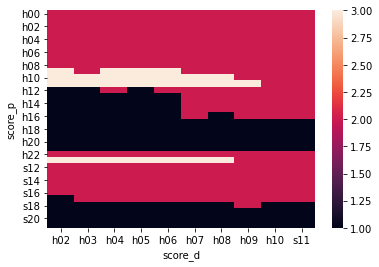

In [42]:
# Visualize the winning action by starting condition
sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack())


<AxesSubplot:xlabel='score_d', ylabel='score_p'>

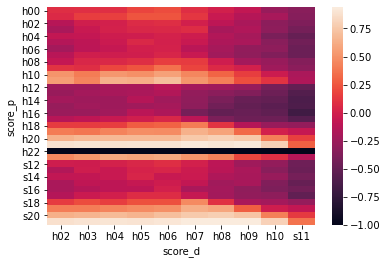

In [43]:
# Visualize the average outcome by starting condition
sns.heatmap(outputs['winning_act_outcome'].unstack())

In [44]:
[(cond, output['winning_act']) for cond, output in conds]

[(<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<fun

In [45]:
strat_derived = generate_strat_conditional(strat_simple, [(cond, output['winning_act']) for cond, output in conds])
strat_derived.name = 'strat_derived'

In [46]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card      hand_end dealer_hand  \
 0         simple    [10, 3]            9   [10, 3, 13]     [9, 13]   
 1  strat_derived    [10, 3]            9    [10, 3, 6]     [9, 13]   
 2         simple     [8, 4]           12    [8, 4, 10]     [12, 7]   
 3  strat_derived     [8, 4]           12  [8, 4, 1, 5]     [12, 7]   
 4         simple   [10, 13]            8      [10, 13]     [8, 13]   
 5  strat_derived   [10, 13]            8      [10, 13]     [8, 13]   
 6         simple     [8, 6]            9  [8, 6, 2, 6]   [9, 3, 5]   
 7  strat_derived     [8, 6]            9  [8, 6, 1, 6]   [9, 3, 5]   
 8         simple    [6, 10]           12   [6, 10, 10]    [12, 13]   
 9  strat_derived    [6, 10]           12    [6, 10, 8]    [12, 13]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.PUSH            0.0         PUSH  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3   HandOutc

In [47]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100*1000)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card       hand_end        dealer_hand  \
 0         simple    [10, 3]           11  [10, 3, 3, 7]            [11, 8]   
 1  strat_derived    [10, 3]           11    [10, 3, 13]            [11, 8]   
 2         simple   [10, 11]            4       [10, 11]  [4, 1, 1, 12, 12]   
 3  strat_derived   [10, 11]            4       [10, 11]  [4, 1, 1, 12, 12]   
 4         simple     [2, 8]           13   [2, 8, 2, 9]     [13, 2, 1, 11]   
 5  strat_derived     [2, 8]           13     [2, 8, 12]     [13, 2, 1, 11]   
 6         simple   [10, 11]            3       [10, 11]       [3, 1, 5, 1]   
 7  strat_derived   [10, 11]            3       [10, 11]       [3, 1, 5, 1]   
 8         simple     [9, 8]            6         [9, 8]       [6, 6, 4, 2]   
 9  strat_derived     [9, 8]            6         [9, 8]       [6, 6, 4, 2]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE       

In [48]:
sims

,strategy,hand_start,dealer_card,hand_end,dealer_hand,outcome,outcome_value,outcome_name
0,simple,"[10, 3]",11,"[10, 3, 3, 7]","[11, 8]",HandOutcome.LOSE,-1.0,LOSE
1,strat_derived,"[10, 3]",11,"[10, 3, 13]","[11, 8]",HandOutcome.LOSE,-1.0,LOSE
2,simple,"[10, 11]",4,"[10, 11]","[4, 1, 1, 12, 12]",HandOutcome.WIN,1.0,WIN
3,strat_derived,"[10, 11]",4,"[10, 11]","[4, 1, 1, 12, 12]",HandOutcome.WIN,1.0,WIN
4,simple,"[2, 8]",13,"[2, 8, 2, 9]","[13, 2, 1, 11]",HandOutcome.WIN,1.0,WIN
...,...,...,...,...,...,...,...,...
199995,strat_derived,"[6, 3]",5,"[6, 3, 8]","[5, 4, 9]",HandOutcome.LOSE_DOUBLE,-2.0,LOSE_DOUBLE
199996,simple,"[8, 3]",1,"[8, 3, 9]","[1, 10]",HandOutcome.LOSE_DOUBLE,-2.0,LOSE_DOUBLE
199997,strat_derived,"[8, 3]",1,"[8, 3, 3, 1, 9]","[1, 10]",HandOutcome.LOSE,-1.0,LOSE
199998,simple,"[12, 10]",3,"[12, 10]","[3, 5, 4, 10]",HandOutcome.WIN,1.0,WIN


In [49]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

def gen_strat_memoized(instructions, strat_base):
    def strat_memoized(score_p, score_d):
        k = (repr(score_p), repr(score_d))
        if k in instructions:
            return instructions[k]
        else:
            return strat_base(score_p, score_d)
    strat_memoized.name = 'memoized'
    return strat_memoized

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = gen_strat_memoized(instructions, strat_simple)

sims = run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), summarize_totals(sims)

(   strategy hand_start  dealer_card          hand_end    dealer_hand  \
 0    simple     [7, 3]            7        [7, 3, 10]     [7, 2, 11]   
 1  memoized     [7, 3]            7      [7, 3, 5, 4]     [7, 2, 11]   
 2    simple    [13, 4]            6           [13, 4]  [6, 4, 2, 10]   
 3  memoized    [13, 4]            6           [13, 4]  [6, 4, 2, 10]   
 4    simple     [3, 1]           10  [3, 1, 2, 12, 8]    [10, 4, 11]   
 5  memoized     [3, 1]           10  [3, 1, 12, 2, 8]    [10, 4, 11]   
 6    simple    [2, 12]            5           [2, 12]   [5, 7, 1, 6]   
 7  memoized    [2, 12]            5           [2, 12]   [5, 7, 1, 6]   
 8    simple    [7, 13]            2           [7, 13]  [2, 2, 9, 12]   
 9  memoized    [7, 13]            2           [7, 13]  [2, 2, 9, 12]   
 
             outcome  outcome_value outcome_name  
 0   HandOutcome.WIN            1.0          WIN  
 1  HandOutcome.PUSH            0.0         PUSH  
 2   HandOutcome.WIN            1.0       

In [50]:
instructions = {(output['score_p'], output['score_d']): output['winning_act'] for cond, output in conds}
instructions

{('h00', 's11'): <Action.HIT: 2>,
 ('h00', 'h02'): <Action.HIT: 2>,
 ('h00', 'h03'): <Action.HIT: 2>,
 ('h00', 'h04'): <Action.HIT: 2>,
 ('h00', 'h05'): <Action.HIT: 2>,
 ('h00', 'h06'): <Action.HIT: 2>,
 ('h00', 'h07'): <Action.HIT: 2>,
 ('h00', 'h08'): <Action.HIT: 2>,
 ('h00', 'h09'): <Action.HIT: 2>,
 ('h00', 'h10'): <Action.HIT: 2>,
 ('h01', 's11'): <Action.HIT: 2>,
 ('h01', 'h02'): <Action.HIT: 2>,
 ('h01', 'h03'): <Action.HIT: 2>,
 ('h01', 'h04'): <Action.HIT: 2>,
 ('h01', 'h05'): <Action.HIT: 2>,
 ('h01', 'h06'): <Action.HIT: 2>,
 ('h01', 'h07'): <Action.HIT: 2>,
 ('h01', 'h08'): <Action.HIT: 2>,
 ('h01', 'h09'): <Action.HIT: 2>,
 ('h01', 'h10'): <Action.HIT: 2>,
 ('h02', 's11'): <Action.HIT: 2>,
 ('h02', 'h02'): <Action.HIT: 2>,
 ('h02', 'h03'): <Action.HIT: 2>,
 ('h02', 'h04'): <Action.HIT: 2>,
 ('h02', 'h05'): <Action.HIT: 2>,
 ('h02', 'h06'): <Action.HIT: 2>,
 ('h02', 'h07'): <Action.HIT: 2>,
 ('h02', 'h08'): <Action.HIT: 2>,
 ('h02', 'h09'): <Action.HIT: 2>,
 ('h02', 'h10'

In [51]:
strat_memoized = gen_strat_memoized(instructions, strat_simple)

sims = run_n_sim_trials([strat_simple, strat_memoized], 100*1000)
sims.head(10), summarize_totals(sims)

(   strategy hand_start  dealer_card       hand_end       dealer_hand  \
 0    simple    [12, 3]            8  [12, 3, 3, 4]            [8, 1]   
 1  memoized    [12, 3]            8     [12, 3, 6]            [8, 1]   
 2    simple   [13, 10]            7       [13, 10]  [7, 3, 3, 3, 11]   
 3  memoized   [13, 10]            7       [13, 10]  [7, 3, 3, 3, 11]   
 4    simple   [12, 12]            3       [12, 12]       [3, 11, 13]   
 5  memoized   [12, 12]            3       [12, 12]       [3, 11, 13]   
 6    simple    [10, 6]            5        [10, 6]        [5, 12, 2]   
 7  memoized    [10, 6]            5        [10, 6]        [5, 12, 2]   
 8    simple    [10, 8]            2        [10, 8]     [2, 5, 8, 13]   
 9  memoized    [10, 8]            2        [10, 8]     [2, 5, 8, 13]   
 
             outcome  outcome_value outcome_name  
 0   HandOutcome.WIN            1.0          WIN  
 1  HandOutcome.PUSH            0.0         PUSH  
 2   HandOutcome.WIN            1.0       